Import Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from collections import Counter
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from wordcloud import WordCloud
import seaborn as sns
import gensim
from gensim import corpora
from gensim.models import CoherenceModel
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import re
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import pyLDAvis.gensim
import warnings

# Ignore the DeprecationWarning
warnings.filterwarnings("ignore", category=DeprecationWarning)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
!pip install pyLDAvis

In [3]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_submission = pd.read_csv('sample_submission.csv')

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [5]:
print(df_train.shape)
print(df_test.shape)
print(df_submission.shape)

(7613, 5)
(3263, 4)
(3263, 2)


In [6]:
print(df_train.columns)
print(df_test.columns)
print(df_submission.columns)

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')
Index(['id', 'keyword', 'location', 'text'], dtype='object')
Index(['id', 'target'], dtype='object')


In [7]:
df_train['keyword'].value_counts()

keyword
fatalities               45
deluge                   42
armageddon               42
sinking                  41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: count, Length: 221, dtype: int64

In [8]:
df_train['location'].value_counts()

location
USA                    104
New York                71
United States           50
London                  45
Canada                  29
                      ... 
MontrÌ©al, QuÌ©bec       1
Montreal                 1
ÌÏT: 6.4682,3.18287      1
Live4Heed??              1
Lincoln                  1
Name: count, Length: 3341, dtype: int64

In [9]:
df_train['target'].value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

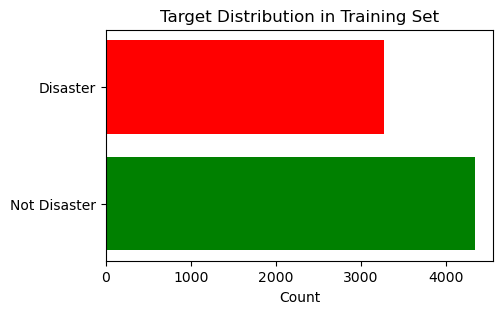

In [10]:
fig, ax = plt.subplots(figsize=(5, 3))

# Get the value counts of the 'target' column in the df_train DataFrame
value_counts = df_train['target'].value_counts()

# Create a horizontal bar plot using the value counts
ax.barh(['Not Disaster', 'Disaster'], value_counts, color=['green', 'red'])

ax.set_xlabel('Count')
ax.set_title('Target Distribution in Training Set')

plt.show()

C:\Users\Dell\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
C:\Users\Dell\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


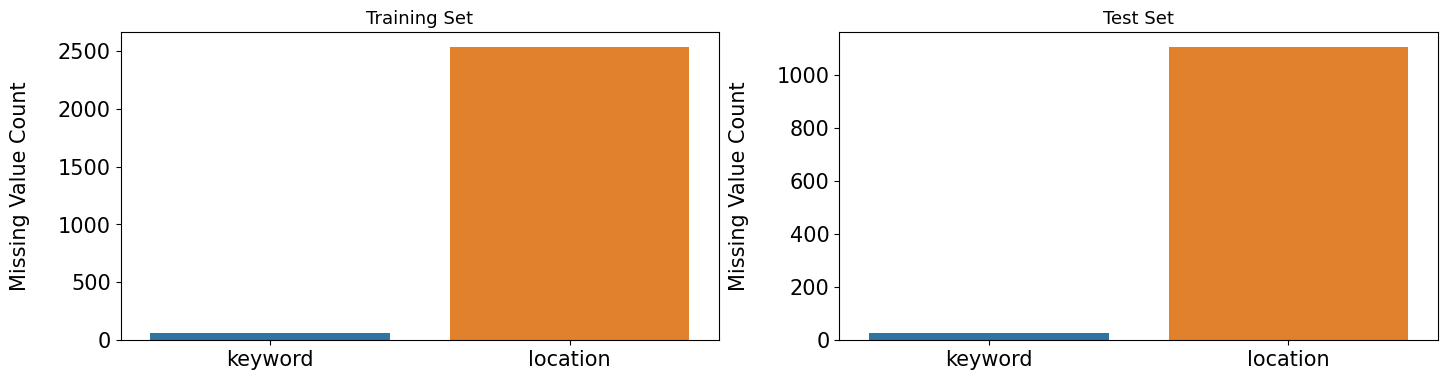

In [11]:
# list of columns with missing values
missing_cols = ['keyword', 'location']

# create bar plots for each set
fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)
for i, df in enumerate([df_train, df_test]):
    sns.barplot(x=missing_cols, y=df[missing_cols].isnull().sum().values, ax=axes[i])
    axes[i].set_ylabel('Missing Value Count', size=15, labelpad=20)
    axes[i].tick_params(axis='x', labelsize=15)
    axes[i].tick_params(axis='y', labelsize=15)
    axes[i].set_title(['Training Set', 'Test Set'][i], fontsize=13)

# impute missing values with "no_{col}"
for df in [df_train, df_test]:
    df[missing_cols] = df[missing_cols].fillna(f'no_{{col}}')

plt.show()

In [56]:
# fill NaN
df_train["keyword"].fillna("None", inplace=True)
df_test["keyword"].fillna("None", inplace=True)

df_train["location"].fillna("None", inplace=True)
df_test["location"].fillna("None", inplace=True)

<ipython-input-56-2e9e99ba31a6>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train["keyword"].fillna("None", inplace=True)
<ipython-input-56-2e9e99ba31a6>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usin

In [57]:
# Combine train and test data for preprocessing
combined_data = pd.concat([df_train, df_test], ignore_index=True)

In [58]:
# Data Cleaning
def clean_text(text):
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    # Convert to lowercase
    text = text.lower()
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text)
    return text

combined_data['cleaned_text'] = combined_data['text'].apply(clean_text)

In [59]:
tfidf = TfidfVectorizer()
features = tfidf.fit_transform(combined_data['cleaned_text'])

In [60]:
df_train_text = df_train.text.values
df_train_labels = df_train.target.values
df_test_text = df_test.text.values

In [61]:
# Removing Stopwords
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Add custom words to the set
custom_stop_words = {"i'm", '&amp;', 'https', 'i', '-','2','3','70','_'}
stop_words.update(custom_stop_words)

# Define a function to remove stop words from a string
def remove_stopwords(text):
    text = " ".join(word.lower() for word in text.split() if word.lower() not in stop_words)
    return text

# Apply the function to the "text" column of the DataFrame
df_train['text'] = df_train['text'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


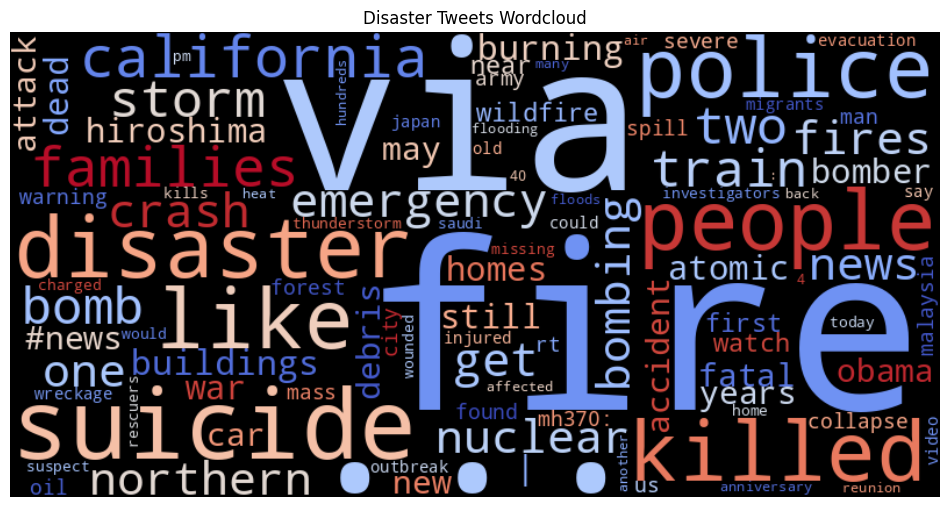

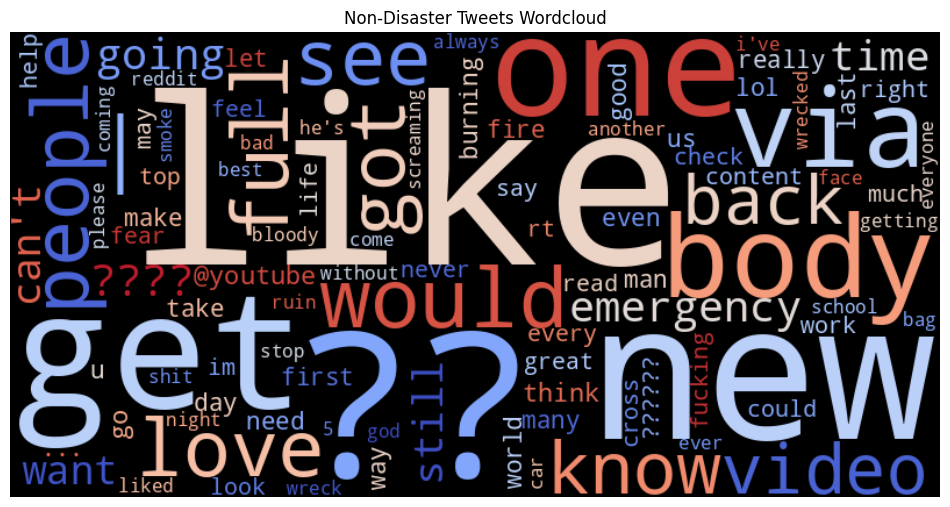

In [62]:
# Define a function to generate a wordcloud
def generate_wordcloud(text, title, max_words = 100):
   # Create a Counter object to count the occurrences of each word
    word_counts = Counter(text.split())

    # Get the most common words and their counts
    common_words = dict(word_counts.most_common(max_words))

    # Create a WordCloud object with some parameters
    wordcloud = WordCloud(width=800, height=400, max_font_size=200, background_color="black", colormap = 'coolwarm').generate_from_frequencies(common_words)

    # Display the generated image with matplotlib
    plt.figure(figsize=(12, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()

# Generate a wordcloud for disaster
text1 = " ".join(review for review in df_train[df_train['target']==1].text)
generate_wordcloud(text1, 'Disaster Tweets Wordcloud')

# Generate a wordcloud for target=0
text0 = " ".join(review for review in df_train[df_train['target']==0].text)
generate_wordcloud(text0, 'Non-Disaster Tweets Wordcloud')

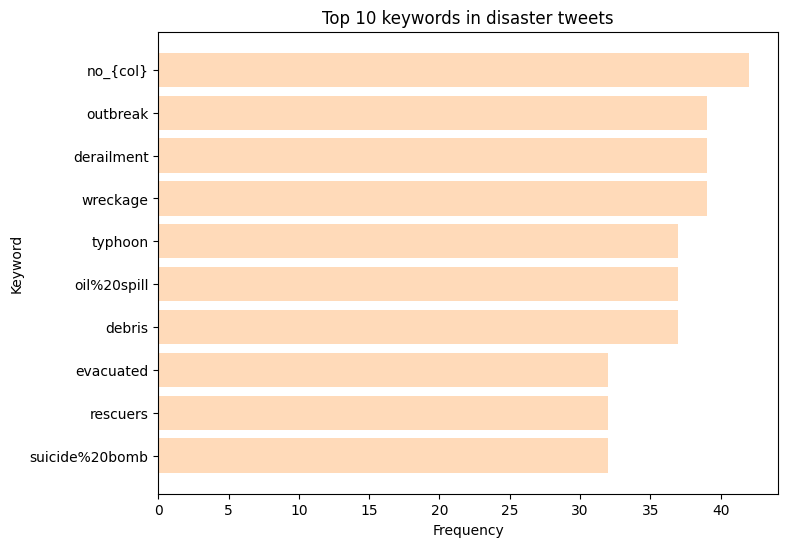

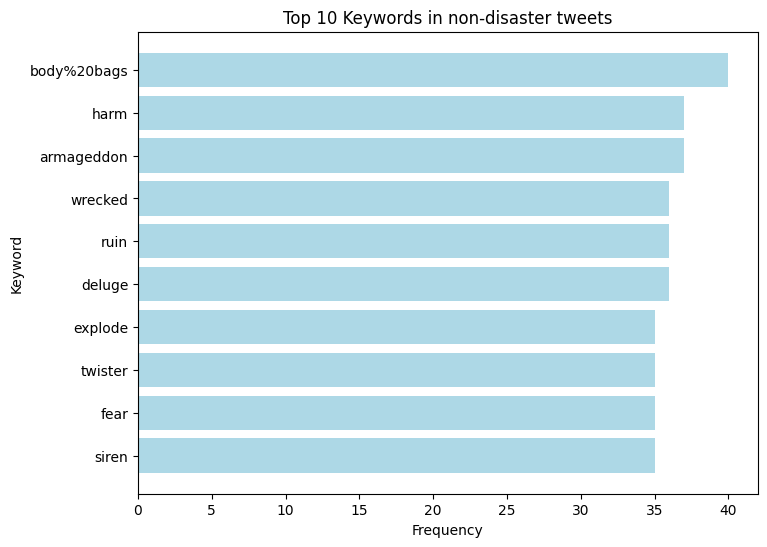

In [63]:
# Get the top 10 most frequent keywords for target = 1
keyword_counts_1 = df_train[df_train['target'] == 1].groupby('keyword').count()['id'].sort_values(ascending=False)[:10]

# Plot the bar chart for target = 1
plt.figure(figsize=(8, 6))
plt.barh(keyword_counts_1.index, keyword_counts_1.values, color='#ffdab9')
plt.title('Top 10 keywords in disaster tweets')
plt.xlabel('Frequency')
plt.ylabel('Keyword')
plt.gca().invert_yaxis()
plt.grid(False)
plt.show()

# Get the top 10 most frequent keywords for target = 0
keyword_counts_0 = df_train[df_train['target'] == 0].groupby('keyword').count()['id'].sort_values(ascending=False)[:10]

# Plot the bar chart for target = 0
plt.figure(figsize=(8, 6))
plt.barh(keyword_counts_0.index, keyword_counts_0.values, color='#add8e6')
plt.title('Top 10 Keywords in non-disaster tweets')
plt.xlabel('Frequency')
plt.ylabel('Keyword')
plt.gca().invert_yaxis()
plt.grid(False)
plt.show()

Topic Modeling using LDA model

In [64]:
# Create a list of documents from the text data
documents = [doc.lower() for doc in list(df_train['text'])]

# Tokenize the documents
tokenized_docs = [doc.lower().split() for doc in documents]

# Create a dictionary from the tokenized documents
dictionary = corpora.Dictionary(tokenized_docs)

# Convert the tokenized documents to a bag-of-words representation
corpus = [dictionary.doc2bow(doc) for doc in tokenized_docs]

Removing stopwords in training data

In [65]:
def remove_stopwords(training_data):
    # Define a list of stopwords to be removed from the training data
    stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at",
                 "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did",
                 "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have",
                 "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself",
                 "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's",
                 "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only",
                 "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd",
                 "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs",
                 "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're",
                 "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we",
                 "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's",
                 "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll",
                 "you're", "you've", "your", "yours", "yourself", "yourselves"]

    # Iterate over each sentence in the training data
    for k in range(len(training_data)):
        # Get a sentence from the training data
        sentence = training_data[k]

        # Convert the sentence to lowercase
        sentence = sentence.lower()

        # Split the sentence into words
        words = sentence.split()

        # Create a new list of words without the stopwords
        no_words = [w for w in words if w not in stopwords]

        # Join the words back into a sentence
        sentence = " ".join(no_words)

        # Replace the original sentence with the modified one in the training data
        training_data[k] = sentence

    # Return the modified training data
    return training_data

# Print the original sentence before cleaning
print("Before cleaning: ", df_train_text[7])

# Call the remove_stopwords function to clean the training data
df_train_text = remove_stopwords(df_train_text)

# Print the cleaned sentence after removing stopwords
print("After cleaning: ", df_train_text[7])

Before cleaning:  I'm on top of the hill and I can see a fire in the woods...
After cleaning:  top hill can see fire woods...


Splitting data for training and validation

In [66]:
TRAINING_SPLIT = 0.8

def train_val_split(texts, labels, training_split):
    # Calculate the size of the training set based on the training split percentage
    train_size = int(len(texts) * training_split)

    # Split the texts and labels into training and validation sets
    train_texts = texts[:train_size]
    train_labels = labels[:train_size]
    validation_texts = texts[train_size:]
    validation_labels = labels[train_size:]

    # Return the training and validation sets
    return train_texts, validation_texts, train_labels, validation_labels

# Call the train_val_split function to split the texts and labels into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_val_split(df_train_text, df_train_labels, TRAINING_SPLIT)

Defining hyperparameters and functions to preprocess and tokenize text data for model

In [67]:
# Hyperparameters
NUM_WORDS = 10000
OOV_TOKEN = "<OOV>"
MAXLEN = 120
PADDING = 'post'
EMBEDDING_DIM = 128
EPOCHS = 5
BATCH_SIZE = 32

def fit_tokenizer(train_texts, num_words, oov_token):
    # Create a tokenizer object with the specified parameters
    tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token)

    # Fit the tokenizer on the training texts to learn the vocabulary
    tokenizer.fit_on_texts(train_texts)

    # Return the fitted tokenizer
    return tokenizer

# Fit the tokenizer on the training texts
tokenizer = fit_tokenizer(train_texts, NUM_WORDS, OOV_TOKEN)

# Get the word index from the fitted tokenizer
word_index = tokenizer.word_index

def seq_and_pad(texts, tokenizer, padding, maxlen):
    # Convert the texts to sequences using the fitted tokenizer
    sequences = tokenizer.texts_to_sequences(texts)

    # Pad the sequences with zeros to ensure uniform length
    padded_sequences = pad_sequences(sequences, maxlen=maxlen, padding=padding)

    # Return the padded sequences
    return padded_sequences

# Convert the training texts to padded sequences
train_padded_seq = seq_and_pad(train_texts, tokenizer, PADDING, MAXLEN)

# Convert the validation texts to padded sequences
val_padded_seq = seq_and_pad(val_texts, tokenizer, PADDING, MAXLEN)

In [68]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=20)

Keras Model

In [69]:
def create_model(num_words, embedding_dim, maxlen):
    tf.random.set_seed(123)
    model_keras = tf.keras.Sequential([
        tf.keras.layers.Embedding(num_words, embedding_dim, input_length=maxlen),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='sigmoid'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model_keras.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
    return model_keras

model_keras = create_model(NUM_WORDS, EMBEDDING_DIM, MAXLEN)
history = model_keras.fit(train_padded_seq, train_labels, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(val_padded_seq, val_labels), callbacks=[early_stopping])

Epoch 1/5
191/191 [==============================] - 4s 18ms/step - loss: 0.7321 - accuracy: 0.5282 - val_loss: 0.6883 - val_accuracy: 0.5345
Epoch 2/5
191/191 [==============================] - 3s 17ms/step - loss: 0.6871 - accuracy: 0.5688 - val_loss: 0.6884 - val_accuracy: 0.5345
Epoch 3/5
191/191 [==============================] - 4s 20ms/step - loss: 0.5955 - accuracy: 0.6859 - val_loss: 0.5494 - val_accuracy: 0.7282
Epoch 4/5
191/191 [==============================] - 3s 18ms/step - loss: 0.4256 - accuracy: 0.8154 - val_loss: 0.4563 - val_accuracy: 0.8011
Epoch 5/5
191/191 [==============================] - 3s 17ms/step - loss: 0.3344 - accuracy: 0.8678 - val_loss: 0.4404 - val_accuracy: 0.8070


In [70]:
# Logistic Regression model training

model = LogisticRegression(max_iter=1000)

train_accuracy_log = []
test_accuracy_log = []

training_set_sizes = np.linspace(0.1, 1.0, 10, endpoint=True)
for training_set_size in training_set_sizes:
    subset_size = int(training_set_size * df_train.shape[0])
    X_subset = train_padded_seq[:subset_size]
    y_subset = train_labels[:subset_size]

    model.fit(X_subset, y_subset)

    # Evaluate the model on the training set
    train_pred = model.predict(X_subset)
    train_acc = accuracy_score(y_subset, train_pred)
    train_accuracy_log.append(train_acc)

    # Evaluate the model on the test set
    test_pred = model.predict(val_padded_seq)
    test_acc = accuracy_score(val_labels, test_pred)
    test_accuracy_log.append(test_acc)
print(train_accuracy_log)
print(test_accuracy_log)

[0.6806833114323259, 0.6576872536136662, 0.6228646517739816, 0.6187192118226601, 0.6003678402522333, 0.5892270637179768, 0.5854756990054419, 0.5876847290640395, 0.5876847290640395, 0.5876847290640395]
[0.5397242284963887, 0.5384110308601444, 0.5364412344057781, 0.5338148391332895, 0.5403808273145109, 0.5370978332239001, 0.5370978332239001, 0.5377544320420223, 0.5377544320420223, 0.5377544320420223]


In [71]:
#Random Forest model training
# Define the parameter grid to search over
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Lists to store accuracy values during training
train_accuracy_tree = []
test_accuracy_tree = []

# Iterate over the parameter grid
for training_set_size in training_set_sizes:
    # Train the model with different hyperparameter settings
    model = RandomForestClassifier()
    subset_size = int(training_set_size * df_train.shape[0])
    X_subset = train_padded_seq[:subset_size]
    y_subset = train_labels[:subset_size]

    model.fit(X_subset, y_subset)

    # Calculate training accuracy
    y_train_pred = model.predict(X_subset)
    train_acc = accuracy_score(y_subset, y_train_pred)
    train_accuracy_tree.append(train_acc)

    # Calculate test accuracy
    y_test_pred = model.predict(val_padded_seq)
    test_acc = accuracy_score(val_labels, y_test_pred)
    test_accuracy_tree.append(test_acc)

print(test_accuracy_tree)

[0.5705843729481287, 0.5607353906762967, 0.5889691398555482, 0.6106369008535785, 0.6296782665791202, 0.6198292843072882, 0.6139198949441891, 0.618516086671044, 0.6211424819435325, 0.6119500984898227]


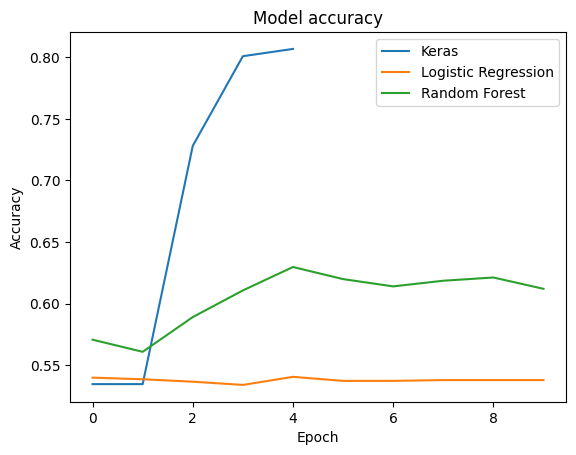

In [72]:
#Finding the best model
plt.plot(history.history['val_accuracy'])
plt.plot(test_accuracy_log)
plt.plot(test_accuracy_tree)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Keras', 'Logistic Regression','Random Forest'], loc='upper right')
plt.show()

In [73]:
# Calculate the maximum accuracy for each model
max_accuracy_tree = np.max(test_accuracy_tree)
max_accuracy_log = np.max(test_accuracy_log)
max_accuracy_keras = np.max(history.history['val_accuracy'])

# Compare the maximum accuracies
models = ['Random Forest', 'Logistic Regression', 'Keras']
max_accuracies = [max_accuracy_tree, max_accuracy_log, max_accuracy_keras]
best_model_index = np.argmax(max_accuracies)
best_model = models[best_model_index]

# Print the best model and its maximum accuracy
print("Best Model:", best_model)
print("Maximum Accuracy:", max_accuracies[best_model_index])

Best Model: Keras
Maximum Accuracy: 0.8069599270820618


Create Submission csv

In [74]:
df_test_pred = remove_stopwords(df_test_text)
test_padded_seq = seq_and_pad(df_test_pred, tokenizer, PADDING, MAXLEN)
df_test_pred = model_keras.predict(test_padded_seq)
df_submission['target'] = df_test_pred.round().astype(int)
df_submission.to_csv('submission4.csv', index=False)

102/102 [==============================] - 0s 4ms/step
